In [ ]:
import os
import torch
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

Using device: cuda


In [ ]:
dataset = datasets.ImageFolder(root='/content/drive/MyDrive/IdentifyTrueDataset/mouse_dataset/mouse_dataset', transform=transform)

In [ ]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
model = models.efficientnet_b0(pretrained=True)
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, 2)

model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 68.1MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 5
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)


    model.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(val_loader)
    val_losses.append(val_loss)
    accuracy = 100 * correct / total

    print(f"Epoch {epoch + 1}/{num_epochs} - "
          f"Train Loss: {epoch_loss:.4f} - "
          f"Val Loss: {val_loss:.4f} - "
          f"Accuracy: {accuracy:.2f}%")

100%|██████████| 90/90 [16:33<00:00, 11.04s/it]


Epoch 1/5 - Train Loss: 0.0697 - Val Loss: 0.0112 - Accuracy: 99.44%


100%|██████████| 90/90 [12:31<00:00,  8.35s/it]


Epoch 2/5 - Train Loss: 0.0154 - Val Loss: 0.0167 - Accuracy: 99.44%


100%|██████████| 90/90 [12:37<00:00,  8.42s/it]


Epoch 3/5 - Train Loss: 0.0095 - Val Loss: 0.0384 - Accuracy: 99.44%


100%|██████████| 90/90 [12:31<00:00,  8.35s/it]


Epoch 4/5 - Train Loss: 0.0126 - Val Loss: 0.0044 - Accuracy: 99.86%


100%|██████████| 90/90 [12:25<00:00,  8.29s/it]


Epoch 5/5 - Train Loss: 0.0110 - Val Loss: 0.0036 - Accuracy: 99.72%


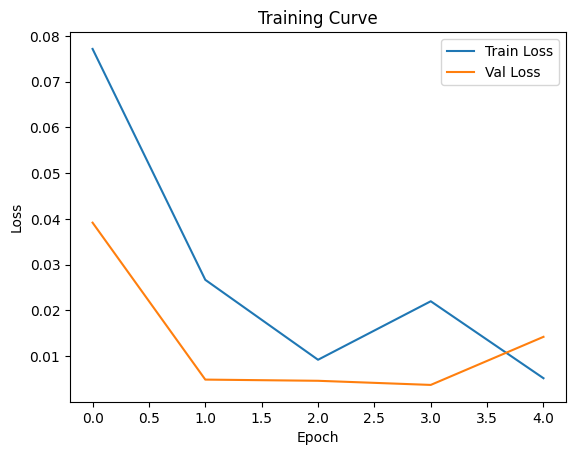

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Curve')
plt.legend()
plt.show()

In [ ]:
torch.save(model.state_dict(), 'mouse_trajectory_model.pth')

In [ ]:
model.state_dict()

OrderedDict([('features.0.0.weight',
              tensor([[[[ 1.2503e-01,  6.6137e-01,  4.6197e-01],
                        [-1.0719e-01, -6.0484e-01, -3.2725e-01],
                        [ 3.0266e-02, -1.0035e-01, -9.6713e-02]],
              
                       [[ 7.1358e-02,  1.6629e+00,  1.7512e+00],
                        [-1.2827e-01, -1.5294e+00, -1.5851e+00],
                        [ 5.6625e-02, -1.0914e-01, -1.1693e-01]],
              
                       [[ 1.0000e-01,  3.7481e-01,  2.8203e-01],
                        [-1.0689e-01, -2.6830e-01, -2.0584e-01],
                        [ 4.7515e-02, -5.8992e-02, -6.7858e-02]]],
              
              
                      [[[ 1.6944e-01, -1.9659e-01,  8.5861e-02],
                        [ 8.9761e-01, -1.2049e+00,  2.8171e-01],
                        [ 1.0828e+00, -1.2515e+00,  2.1287e-01]],
              
                       [[ 3.2697e-01, -4.3661e-01,  1.8432e-01],
                        [ 1.6219e+00, 